+ Reference : https://github.com/chrischute/real-nvp

In [1]:
# !git clone "https://github.com/chrischute/real-nvp".git

In [2]:
cd real-nvp

/home/sh/lab/GAN/real-nvp


In [3]:
"""Train Real NVP on CIFAR-10.

Train script adapted from: https://github.com/kuangliu/pytorch-cifar/
"""
import argparse
import os
import torch
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

import util
from models import RealNVP, RealNVPLoss

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
batch_size = 64
benchmark = True
lr = 1e-3
max_grad_norm = 100
num_epochs = 100
num_samples = 64

resume = 'r'
weight_decay = 5e-5

best_loss = 0

# Data Load

In [5]:
# Note: No normalization applied, since RealNVP expects inputs in (0, 1).
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])

trainset = torchvision.datasets.CIFAR10(root='data', train=True, download=False, transform=transform_train)
trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='data', train=False, download=False, transform=transform_test)
testloader = data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

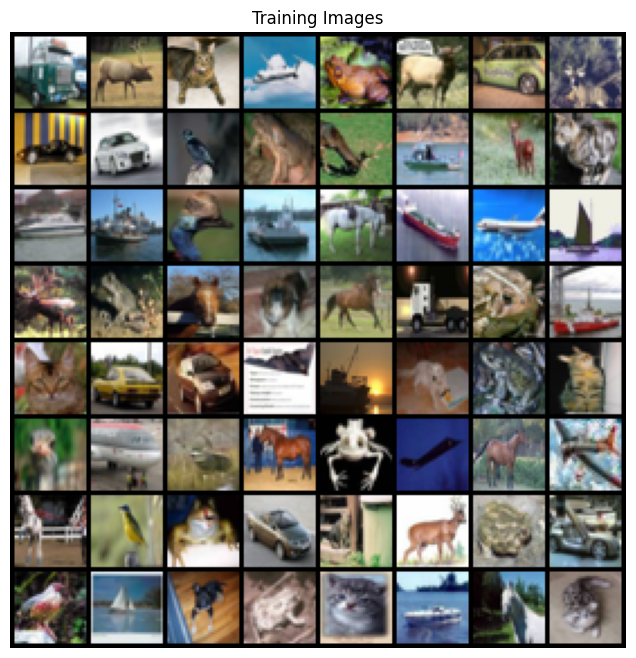

In [6]:
one_batch = next(iter(trainloader))
plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(one_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# Train

In [7]:
def train(epoch, net, trainloader, device, optimizer, loss_fn, max_grad_norm):
    print('\nEpoch: %d' % epoch)
    net.train()
    loss_meter = util.AverageMeter()
    with tqdm(total=len(trainloader.dataset)) as progress_bar:
        for x, _ in trainloader:
            x = x.to(device)
            optimizer.zero_grad()
            z, sldj = net(x, reverse=False)
            loss = loss_fn(z, sldj)
            loss_meter.update(loss.item(), x.size(0))
            loss.backward()
            util.clip_grad_norm(optimizer, max_grad_norm)
            optimizer.step()

            progress_bar.set_postfix(loss=loss_meter.avg,
                                     bpd=util.bits_per_dim(x, loss_meter.avg))
            progress_bar.update(x.size(0))

In [8]:
def test(epoch, net, testloader, device, loss_fn, num_samples):
    global best_loss
    net.eval()
    loss_meter = util.AverageMeter()
    with torch.no_grad():
        with tqdm(total=len(testloader.dataset)) as progress_bar:
            for x, _ in testloader:
                x = x.to(device)
                z, sldj = net(x, reverse=False)
                loss = loss_fn(z, sldj)
                loss_meter.update(loss.item(), x.size(0))
                progress_bar.set_postfix(loss=loss_meter.avg,
                                         bpd=util.bits_per_dim(x, loss_meter.avg))
                progress_bar.update(x.size(0))

    # Save checkpoint
    if loss_meter.avg < best_loss:
        print('Saving...')
        state = {
            'net': net.state_dict(),
            'test_loss': loss_meter.avg,
            'epoch': epoch,
        }
        os.makedirs('ckpts', exist_ok=True)
        torch.save(state, 'ckpts/best.pth.tar')
        best_loss = loss_meter.avg

    # Save samples and data
    images = sample(net, num_samples, device)
    os.makedirs('samples', exist_ok=True)
    images_concat = torchvision.utils.make_grid(images, nrow=int(num_samples ** 0.5), padding=2, pad_value=255)
    torchvision.utils.save_image(images_concat, 'samples/epoch_{}.png'.format(epoch))


In [9]:
def main():
    start_epoch = 0
    
    # Model
    net = RealNVP(num_scales=2, in_channels=3, mid_channels=64, num_blocks=8)
    net = net.to(device)

    loss_fn = RealNVPLoss()
    param_groups = util.get_param_groups(net, weight_decay, norm_suffix='weight_g')
    optimizer = optim.Adam(param_groups, lr=lr)

    for epoch in range(start_epoch, start_epoch + num_epochs):
        train(epoch, net, trainloader, device, optimizer, loss_fn, max_grad_norm)
        test(epoch, net, testloader, device, loss_fn, num_samples)


In [10]:
def sample(net, batch_size, device):
    """Sample from RealNVP model.

    Args:
        net (torch.nn.DataParallel): The RealNVP model wrapped in DataParallel.
        batch_size (int): Number of samples to generate.
        device (torch.device): Device to use.
    """
    z = torch.randn((batch_size, 3, 32, 32), dtype=torch.float32, device=device)
    x, _ = net(z, reverse=True)
    x = torch.sigmoid(x)

    return x

In [11]:
main()


Epoch: 0


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 888.73it/s, bpd=4.27, loss=9.1e+3]



Epoch: 1


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 896.72it/s, bpd=4.18, loss=8.91e+3]



Epoch: 2


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 900.89it/s, bpd=4.54, loss=9.66e+3]



Epoch: 3


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 899.79it/s, bpd=12.1, loss=2.58e+4]



Epoch: 4


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 900.34it/s, bpd=5.03, loss=1.07e+4]



Epoch: 5


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 894.80it/s, bpd=11.5, loss=2.45e+4]



Epoch: 6


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 900.47it/s, bpd=3.91, loss=8.33e+3]



Epoch: 7


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 899.72it/s, bpd=4.27, loss=9.1e+3]



Epoch: 8


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 901.76it/s, bpd=3.74, loss=7.96e+3]



Epoch: 9


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 901.26it/s, bpd=4.16, loss=8.85e+3]



Epoch: 10


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 900.87it/s, bpd=4.11, loss=8.76e+3]



Epoch: 11


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 900.27it/s, bpd=3.71, loss=7.9e+3]



Epoch: 12


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 903.50it/s, bpd=3.91, loss=8.33e+3]



Epoch: 13


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 912.29it/s, bpd=3.72, loss=7.91e+3]



Epoch: 14


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.38it/s, bpd=5.15, loss=1.1e+4]



Epoch: 15


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 912.23it/s, bpd=3.75, loss=7.98e+3]



Epoch: 16


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.99it/s, bpd=120, loss=2.56e+5]



Epoch: 17


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.45it/s, bpd=3.81, loss=8.11e+3]



Epoch: 18


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.25it/s, bpd=3.93, loss=8.36e+3]



Epoch: 19


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.24it/s, bpd=3.7, loss=7.88e+3]



Epoch: 20


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.02it/s, bpd=12.8, loss=2.72e+4]



Epoch: 21


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.54it/s, bpd=3.67, loss=7.82e+3]



Epoch: 22


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.86it/s, bpd=4.73, loss=1.01e+4]



Epoch: 23


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.43it/s, bpd=4.1, loss=8.74e+3]



Epoch: 24


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.08it/s, bpd=3.67, loss=7.81e+3]



Epoch: 25


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.91it/s, bpd=3.58, loss=7.63e+3]



Epoch: 26


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.10it/s, bpd=3.73, loss=7.94e+3]



Epoch: 27


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.28it/s, bpd=3.62, loss=7.7e+3]



Epoch: 28


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.59it/s, bpd=3.62, loss=7.71e+3]



Epoch: 29


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.39it/s, bpd=3.61, loss=7.69e+3]



Epoch: 30


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.56it/s, bpd=3.71, loss=7.9e+3]



Epoch: 31


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 908.82it/s, bpd=3.6, loss=7.67e+3]



Epoch: 32


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 908.87it/s, bpd=3.61, loss=7.69e+3]



Epoch: 33


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.76it/s, bpd=3.58, loss=7.62e+3]



Epoch: 34


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 910.34it/s, bpd=3.72, loss=7.92e+3]



Epoch: 35


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 909.92it/s, bpd=3.56, loss=7.59e+3]



Epoch: 36


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 908.85it/s, bpd=7.85, loss=1.67e+4]



Epoch: 37


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 909.37it/s, bpd=3.6, loss=7.66e+3]



Epoch: 38


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 908.91it/s, bpd=3.65, loss=7.77e+3]



Epoch: 39


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 910.19it/s, bpd=3.64, loss=7.75e+3]



Epoch: 40


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 909.75it/s, bpd=3.61, loss=7.69e+3]



Epoch: 41


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 908.25it/s, bpd=3.61, loss=7.68e+3]



Epoch: 42


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 910.17it/s, bpd=3.85, loss=8.2e+3]



Epoch: 43


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 909.20it/s, bpd=3.54, loss=7.54e+3]



Epoch: 44


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 910.44it/s, bpd=3.56, loss=7.58e+3]



Epoch: 45


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 909.88it/s, bpd=4.1, loss=8.73e+3]



Epoch: 46


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 910.92it/s, bpd=3.69, loss=7.87e+3]



Epoch: 47


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 909.33it/s, bpd=61.5, loss=1.31e+5]



Epoch: 48


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.38it/s, bpd=3.58, loss=7.63e+3]



Epoch: 49


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.19it/s, bpd=3.53, loss=7.51e+3]



Epoch: 50


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.62it/s, bpd=3.72, loss=7.92e+3]



Epoch: 51


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.38it/s, bpd=3.54, loss=7.54e+3]



Epoch: 52


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.43it/s, bpd=3.63, loss=7.74e+3]



Epoch: 53


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.60it/s, bpd=3.55, loss=7.56e+3]



Epoch: 54


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.36it/s, bpd=3.53, loss=7.52e+3]



Epoch: 55


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.83it/s, bpd=3.6, loss=7.66e+3]



Epoch: 56


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.05it/s, bpd=3.78, loss=8.06e+3]



Epoch: 57


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.87it/s, bpd=3.7, loss=7.89e+3]



Epoch: 58


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.66it/s, bpd=3.84, loss=8.19e+3]



Epoch: 59


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 909.21it/s, bpd=3.77, loss=8.04e+3]



Epoch: 60


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 908.65it/s, bpd=4.22, loss=8.99e+3]



Epoch: 61


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.10it/s, bpd=3.66, loss=7.8e+3]



Epoch: 62


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.26it/s, bpd=3.92, loss=8.34e+3]



Epoch: 63


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.55it/s, bpd=3.57, loss=7.6e+3]



Epoch: 64


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 908.17it/s, bpd=4.61, loss=9.82e+3]



Epoch: 65


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 908.02it/s, bpd=4.93, loss=1.05e+4]



Epoch: 66


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 908.01it/s, bpd=3.69, loss=7.86e+3]



Epoch: 67


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 910.26it/s, bpd=3.67, loss=7.82e+3]



Epoch: 68


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 910.26it/s, bpd=4.32, loss=9.2e+3]



Epoch: 69


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 909.97it/s, bpd=11.1, loss=2.36e+4]



Epoch: 70


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 909.23it/s, bpd=4.52, loss=9.63e+3]



Epoch: 71


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 909.36it/s, bpd=5.22, loss=1.11e+4]



Epoch: 72


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.19it/s, bpd=4.41, loss=9.39e+3]



Epoch: 73


100%|███████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.64it/s, bpd=4, loss=8.52e+3]



Epoch: 74


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.00it/s, bpd=3.85, loss=8.21e+3]



Epoch: 75


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 909.04it/s, bpd=3.51, loss=7.47e+3]



Epoch: 76


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.16it/s, bpd=3.81, loss=8.12e+3]



Epoch: 77


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.23it/s, bpd=8.48, loss=1.81e+4]



Epoch: 78


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.76it/s, bpd=4.97, loss=1.06e+4]



Epoch: 79


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.84it/s, bpd=5.81, loss=1.24e+4]



Epoch: 80


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.88it/s, bpd=8.83, loss=1.88e+4]



Epoch: 81


100%|██████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.53it/s, bpd=11, loss=2.34e+4]



Epoch: 82


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.34it/s, bpd=3.5, loss=7.46e+3]



Epoch: 83


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.45it/s, bpd=4.57, loss=9.72e+3]



Epoch: 84


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.85it/s, bpd=5.74, loss=1.22e+4]



Epoch: 85


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.78it/s, bpd=6.2, loss=1.32e+4]



Epoch: 86


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.00it/s, bpd=7.05, loss=1.5e+4]



Epoch: 87


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 903.87it/s, bpd=6.01, loss=1.28e+4]



Epoch: 88


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.13it/s, bpd=3.64, loss=7.76e+3]



Epoch: 89


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.12it/s, bpd=6.35, loss=1.35e+4]



Epoch: 90


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.89it/s, bpd=27.6, loss=5.89e+4]



Epoch: 91


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.54it/s, bpd=12.1, loss=2.57e+4]



Epoch: 92


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.65it/s, bpd=12.4, loss=2.64e+4]



Epoch: 93


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 905.99it/s, bpd=11.1, loss=2.36e+4]



Epoch: 94


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.67it/s, bpd=21.5, loss=4.58e+4]



Epoch: 95


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.20it/s, bpd=9.91, loss=2.11e+4]



Epoch: 96


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 906.51it/s, bpd=96.9, loss=2.06e+5]



Epoch: 97


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 904.74it/s, bpd=32.9, loss=7.01e+4]



Epoch: 98


100%|█████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 907.21it/s, bpd=3.8, loss=8.09e+3]



Epoch: 99


100%|████████████████████████████████████████████████████████████| 10000/10000 [00:10<00:00, 909.50it/s, bpd=5.99, loss=1.27e+4]
